<a href="https://colab.research.google.com/github/VangsillEE/ComputerVision_Seminar/blob/main/%EA%B3%BC%EC%A0%9C/%EC%98%A4%ED%98%95%EC%84%9D_CV_seminar_week4_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
import matplotlib.pyplot as plt
import glob
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image as PILImage
import numpy as np

In [ ]:
dolphin_img_list = glob.glob('/content/drive/MyDrive/CV_seminar_project/test/dolphin/*')
shark_img_list = glob.glob('/content/drive/MyDrive/CV_seminar_project/test/shark/*')
whale_img_list = glob.glob('/content/drive/MyDrive/CV_seminar_project/test/whale/*')

In [ ]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [ ]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [ ]:
device

'cuda'

In [ ]:
root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
test_path = '/content/drive/MyDrive/CV_seminar_project/test'

In [ ]:
preprop_imgs = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor()
     ]
)

preprop_train = torchvision.datasets.ImageFolder(root = train_path, transform=preprop_imgs)
preprop_test = torchvision.datasets.ImageFolder(root = test_path, transform=preprop_imgs)

In [ ]:
preprop_train[0][0]

tensor([[[0.3098, 0.3333, 0.3608,  ..., 0.6471, 0.6706, 0.6706],
         [0.3569, 0.3804, 0.4157,  ..., 0.6588, 0.6510, 0.6510],
         [0.3412, 0.3647, 0.4000,  ..., 0.6706, 0.6627, 0.6627],
         ...,
         [0.1765, 0.1725, 0.1686,  ..., 0.2627, 0.2784, 0.2784],
         [0.1922, 0.1843, 0.1804,  ..., 0.2745, 0.2784, 0.2784],
         [0.1922, 0.1843, 0.1804,  ..., 0.2745, 0.2784, 0.2784]],

        [[0.6314, 0.6549, 0.6824,  ..., 0.8549, 0.8667, 0.8667],
         [0.6902, 0.7137, 0.7412,  ..., 0.8706, 0.8471, 0.8471],
         [0.6824, 0.7059, 0.7412,  ..., 0.8863, 0.8627, 0.8627],
         ...,
         [0.6431, 0.6431, 0.6392,  ..., 0.6784, 0.6824, 0.6824],
         [0.6431, 0.6431, 0.6392,  ..., 0.6784, 0.6745, 0.6745],
         [0.6431, 0.6431, 0.6392,  ..., 0.6784, 0.6745, 0.6745]],

        [[0.8157, 0.8392, 0.8667,  ..., 0.9294, 0.9647, 0.9647],
         [0.8706, 0.8941, 0.9255,  ..., 0.9569, 0.9569, 0.9569],
         [0.8706, 0.8941, 0.9294,  ..., 0.9882, 0.9843, 0.

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [ ]:
train_class.all_data[0]

'/content/drive/MyDrive/CV_seminar_project/train/dolphin/dolphin_000.jpg'

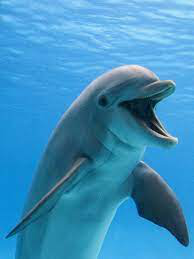

In [ ]:
from PIL import Image as PILImage
PILImage.open(train_class.all_data[0])

In [ ]:
train_class[0][0] # 역함수를 이용해 이것을 시각화 해주세요.

tensor([[[-1.2788, -1.3130, -1.3302,  ..., -0.9363, -0.9020, -0.9020],
         [-1.2788, -1.3130, -1.3302,  ..., -0.9363, -0.9192, -0.9192],
         [-1.3644, -1.3644, -1.3815,  ..., -0.9705, -0.9363, -0.9192],
         ...,
         [-0.5938, -0.5082, -0.3541,  ...,  0.8104,  0.7419,  0.7419],
         [-0.5424, -0.4568, -0.3027,  ...,  0.7762,  0.7077,  0.7077],
         [-0.7993, -0.6965, -0.5767,  ...,  0.7077,  0.8104,  0.8104]],

        [[ 0.8354,  0.8354,  0.8179,  ...,  0.9930,  0.9580,  0.9755],
         [ 0.8354,  0.8354,  0.8179,  ...,  0.9930,  0.9580,  0.9755],
         [ 0.8179,  0.8179,  0.8179,  ...,  0.9930,  1.0105,  1.0105],
         ...,
         [ 1.0105,  1.1331,  1.2556,  ...,  1.9209,  1.8333,  1.8158],
         [ 1.0105,  1.1331,  1.2731,  ...,  1.8333,  1.7633,  1.7458],
         [ 0.7479,  0.8704,  0.9755,  ...,  1.7633,  1.8333,  1.8333]],

        [[ 2.2217,  2.2217,  2.2043,  ...,  2.2217,  2.1868,  2.1694],
         [ 2.2217,  2.2217,  2.2043,  ...,  2

### 과제1

In [ ]:
import albumentations
import albumentations.pytorch

albumentations = albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.RandomBrightnessContrast(p=1),
    albumentations.RandomGamma(p=1),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50,
                                      val_shift_limit=50, p=1)
]
)
pytorch_dataset = Custom_dataset(root_path = root_path, mode = 'train', transforms = albumentations) 

###과제2

In [ ]:
def converter(augmentationed_image):
  ### 역함수 로직을 짜주세요. ###
  mean = (0.485, 0.456, 0.406)
  std=(0.229, 0.224, 0.225)
  converted_image = augmentationed_image.numpy().copy()
  for i in range(3):
    converted_image[i] = (converted_image[i]*std[i] + mean[i])
  converted_image = converted_image.transpose(1,2,0)
  converted_image = converted_image[:,:,::-1]
  return converted_image

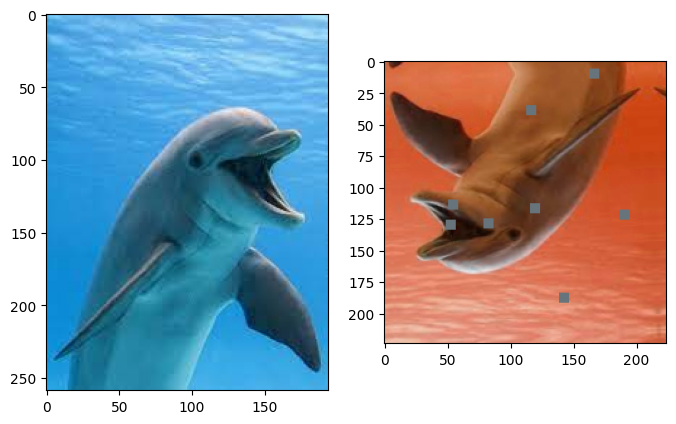

In [ ]:
plt.figure(figsize =(8,8),dpi=100)
plt.subplot(1,2,1)
plt.imshow(cv2.imread(train_class.all_data[0])[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(converter(train_class[0][0]))